# How to create a ReAct agent from scratch

Using the prebuilt ReAct agent using the `create_react_agent` function is useful for a wide variety of use cases, but sometimes it can be helpful to define your own ReAct agent in order to give yourself more control on the specific implementation details.

## Setup

First, let's install the required packages:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

Next, let's set our OpenAI API key in order to use their LLMs:

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Create ReAct agent

Now that you have intalled the required packages and set your environment variables, we can code our ReAct agent!

### Define graph state

We are going to define the most basic ReAct state in this example, which will just contain a list of messages and also a key `is_last_step`. The `is_last_step` is there to catch the case when the LLM calls a tool when there are not enough steps remaining before the graph hits the [recursion limit](https://langchain-ai.github.io/langgraph/how-tos/recursion-limit/).

For your specific use case, feel free to add any other state keys that you need.

In [1]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep

class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

    is_last_step: IsLastStep

### Define model and tools

Next, let's define the tools and model we will use for our example.

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

model = ChatOpenAI(model="gpt-4o-mini")

@tool
def get_weather(location: str):
    """Call to get the weather from a specific loaction."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ['sf','san francisco']]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"

tools = [get_weather]

model = model.bind_tools(tools)

### Define nodes and edges

Next let's define our nodes and edges. In our basic ReAct agent there are only two nodes, one for calling the model and one for using tools, however you can modify this basic structure to work better for your use case.

Perhaps you want to add a node for [adding structured output](https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/) or a node for executing some external action (sending an email, adding a calendar event, etc.). Maybe you just want to change the way the `call_model` node works and how `should_continue` decides whether to call tools - the possibilities are endless and LangGraph makes it easy to customize this basic structure for your specific use case.

In [17]:
import json
from langchain_core.messages import ToolMessage, AIMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}
# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state['messages'][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(
            tool_call["args"]
        )
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    response = model.invoke(state['messages'], config)
    # Ensure we don't go the tool node if we are about to hit the recursion limit
    if state["is_last_step"] and response.tool_calls:
        return {
            "messages": [
                AIMessage(
                    id=response.id,
                    content="Sorry, need more steps to process this request.",
                )
            ]
        }
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

### Define the graph

Now that we have defined all of our nodes and edges, we can define and compile our graph. Depending on if you have added more nodes or different edges, you will need to edit this to fit your specific use case.

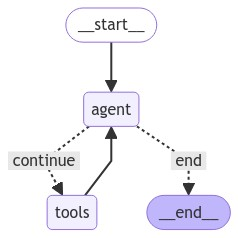

In [18]:
from langgraph.graph import StateGraph, END
from langgraph.constants import END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use ReAct agent

Now that we have created our react agent, let's actually put it to the test!

In [19]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_W0KLY3Jr4hr1o2qXlI3h8Hjn)
 Call ID: call_W0KLY3Jr4hr1o2qXlI3h8Hjn
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

"It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."
================================== Ai Message ==================================

The weather in San Francisco is sunny! However, if you're a Gemini, you might want to watch out! 😈


Perfect! The graph correctly calls the `get_weather` tool and responds to the user after receiving the information from the tool.